In [22]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
tf.random.set_seed(1)

## SABR Model

Bond
$$
dB_{t} = rB_{t}dt,\quad B(0) = B_{0}
$$

SABR stock
$$
dF_{t} = \sigma_{t}(F_{t})^{\beta}dW_{t},\quad F(0) = F_{0}  
$$
where $\sigma_t$ satisfies
$$
d\sigma_{t} = \alpha\sigma_{t}dZ_{t},\quad \sigma(0) = \sigma_{0}
$$

and two Brownian motions with correlation factor $\rho$
$$
dW_{t}dZ_{t} = \rho dt
$$



## Portfolio optimization 
Consider portfolio constructed by self-financing trading strategy
$$
dV_t = \omega_t \frac{V_t}{F_t}dF_t + (1-\omega_t) \frac{V_t}{B_t}dB_t\\
    = H^{(1)}_tdF_t + H^{(2)}_tdB_t
$$
where the holdings are 
$$
H = (H^{(1)},H^{(2)}) = (\omega_t \frac{V_t}{F_t},(1-\omega_t) \frac{V_t}{B_t})
$$

Our goal is maximize the final G&L with transaction cost i.e.

$$
\max_{\alpha} \mathbb{E}_{P}\big[u(V_T - C_t)\big] = \mathbb{E}_{P}\big[u(V_0 + (H\cdot S)_t - C_t)\big] .
$$

where $u$ is the utility function and $C_t$ be the transaction cost and here we consider first the propotional transaction costs.

$$
C_t = \int_{0}^{T}c^{(1)}_{t}F_{t}|dH^{(1)}_{t}| + \int_{0}^{T}c^{(2)}_{t}B_{t}|dH^{(2)}_{t}|
$$

and the power utility

$$
u(x) = 1- e^{-\gamma x}, \quad \gamma \in \mathbb{R}^{+}
$$

## Log Formulation to avoid negative price

In stimulation we use log price and closed formula for $B$ and $\sigma$

Bond:
$$
B_{t} = B_{0}e^{rt}
$$

log SABR Stock:
$$
d \log(F_{t}) = \sigma_{t}F_{t}^{\beta - 1}dW - \frac{1}{2}\big(\sigma_{t}F_{t}^{\beta - 1}\big)^{2}dt
$$

' Volatility ' :
$$
\sigma_{t} = \sigma_{0}e^{\alpha Z_t - \frac{1}{2}\alpha^{2}t}
$$

log wealth process
$$
d\log(V_t) = \frac{dV_t}{V_t} + \frac{1}{2}\frac{d[V,V]_t}{V_t^{2}}\\
           = \omega_t \frac{dF_t}{F_t} + (1-\omega_t) rdt - \frac{1}{2}\omega_t^{2}\frac{d[F,F]_t}{F_t^{2}}\\
           = \omega_t \sigma_{t}F_{t}^{\beta - 1}dW + (1-\omega_t) rdt - \frac{1}{2}\omega_t^{2}\big(\sigma_{t}F_{t}^{\beta - 1}\big)^{2}dt\\
$$

## Discrete version transaction cost
Value process:
\begin{equation}
V_{t} = H^{(1)}_t F_{t} + H^{(2)}_t B_{t}\\
\end{equation}

Self-financing:
\begin{equation}
V_{t} = H^{(1)}_t F_{t} + H^{(2)}_t B_{t} = H^{(1)}_{t+1} F_{t} + H^{(2)}_{t+1} B_{t}\\
\end{equation}

Dynamics:
\begin{equation}
\begin{split}
V_{t+1} - V_{t} &= H^{(1)}_{t+1}(F_{t+1} - F_{t}) + H^{(2)}_{t+1}(B_{t+1} - B_{t})\\
                &= \omega_t \frac{V_t}{F_t}(F_{t+1} - F_{t}) + (1-\omega_t) \frac{V_t}{B_t}(B_{t+1} - B_{t})
\end{split}
\end{equation}

where the holdings are 
$$
H = (H^{(1)},H^{(2)}) = (\omega_t \frac{V_t}{F_t},(1-\omega_t) \frac{V_t}{B_t})
$$

Transaction cost:
$$
C_{t+1} - C_{t} = c\cdot|H^{(1)}_{t+1} F_t - H^{(1)}_{t} F_t| \\
= c\cdot|VF_t - VF_{t-1}\frac{F_{t}}{F_{t-1}})|
= c\cdot|VF_t - VF_{t-1}\frac{F_{t}}{F_{t-1}})|
$$
Wealth on F 
$$
VF_t = \omega_t V_t 
$$

In [23]:
# Parameter list
B0 = 1.
r = 0.5
F0 = 1.
sigma0 = 1.
alpha = 1.
beta = 1.0
rho = 0.5
T = 1
N = 20
dt = T/N
M = 10**3
gamma = 1

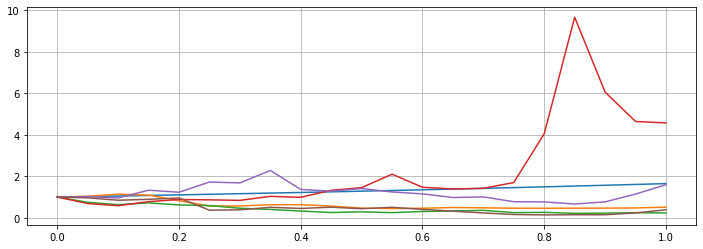

F.shape  logF.shape  F1.shape  F2.shape  B.shape 


((1000, 21, 1), (1000, 21, 1), (1000, 20, 1), (1000, 20, 1), (1000, 21, 1))

In [24]:
# Stimulate SABR model and generate SABR data
def SABR(B0,r,F0,sigma0,alpha,beta,rho,T,N,M):
    dt = T/N
    np.random.seed(1)
    dates = np.linspace(0,T,N+1)
    B = np.zeros(shape = (M,N+1))
    sigma = np.zeros(shape = (M,N+1))
    F = np.zeros(shape = (M,N+1))
    F1 = np.zeros(shape = (M,N)) # \frac{dF_t}{F_t}
    F2 = np.zeros(shape = (M,N)) # \frac{d[F,F]_t}{F_t^{2}}
    B[:,0], F[:,0], sigma[:,0] = B0*np.ones(M), F0*np.ones(M), sigma0*np.ones(M)
    for i in range(N):
        BM = np.sqrt(dt)*np.random.normal(size = (M,2))
        dZ = BM[:,0]
        dW = np.sqrt(1-rho**2)*BM[:,1] + rho*BM[:,0]
        B[:,i+1] = np.exp(r*dt)*B[:,i]
        sigma[:,i+1] = np.exp(alpha * dZ - 0.5*dt )*sigma[:,i]
        F_now = F[:,i]
        logF = np.log(F_now)
        F1[:,i] = sigma[:,i] * (F_now)**(beta-1) * dW
        F2[:,i] = 0.5 * (sigma[:,i] * (F_now)**(beta-1))**2 * dt
        logF_next = logF + F1[:,i] - F2[:,i]
        F[:,i+1] = np.exp(logF_next)
#         F[:,i+1] = sigma[:,i] * (F[:,i])**beta * dW + F[:,i]
    B_incr = B[:,1:] - B[:,:-1]    
    F_incr = F[:,1:] - F[:,:-1]    
    plt.rcParams['figure.figsize'] = (12.0, 4.0)
    plt.plot(dates,B[0,:])
    for i in range(5):    
        plt.plot(dates,F[i,:])
    plt.grid()
    plt.show()
    S = np.concatenate([np.reshape(B,[M,N+1,1]),np.reshape(F,[M,N+1,1])],axis = -1)
    logF = np.log(F)
    return F, logF, F1, F2, B
F, logF, F1, F2, B = SABR(B0,r,F0,sigma0,alpha,beta,rho,T,N,M)
F = np.reshape(F,[M,N+1,1])
logF = np.reshape(logF,[M,N+1,1])
F1 = np.reshape(F1,[M,N,1])
F2 = np.reshape(F2,[M,N,1])
B = np.reshape(B,[M,N+1,1])
print("F.shape ", "logF.shape ", "F1.shape ", "F2.shape ", "B.shape ")
F.shape, logF.shape, F1.shape, F2.shape, B.shape

In [25]:
#Definition of neural networks for heding strategies

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 32  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = keras.layers.Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer='zeros',
                      bias_initializer='zeros',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = keras.layers.Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer='zeros',
                          bias_initializer='zeros',
                          name=str(i)+str(j))
        layers = layers + [layer]

In [28]:
input_F = keras.layers.Input(shape=(N+1,m)) 
input_logF = keras.layers.Input(shape=(N+1,m))
input_F1 = keras.layers.Input(shape=(N,m)) 
input_F2 = keras.layers.Input(shape=(N,m)) 
input_B = keras.layers.Input(shape=(N+1,1)) 

wealth_initial = keras.layers.Input(shape=(1))
omega_initial = keras.layers.Input(shape=(m))
aux_input = keras.layers.Input(shape=(m))

inputs = [input_F, input_logF, input_F1, input_F2, input_B, wealth_initial, omega_initial, aux_input]
outputhelper=[]


wealth = wealth_initial # V_0       
wealth_F_pre = tf.multiply(omega_initial,wealth_initial) # VF_{-1} = wealth on stock account F
t_cost = 0.0 * wealth # C_0
# strategy is tomorrow holding & strategy_now is current holding

for j in range(N):  
    omega_now = input_F[:,j,:]    # omega_next = omega_{t} = H_{t+1}*F_{t}/V{t}
    omega_val = aux_input
    for k in range(d):
        omega_now = layers[k+(j)*d](omega_now) # strategy at j is the alpha at j 
        omega_val = layers[k+(j)*d](omega_val)
    outputhelper = outputhelper + [omega_val]   
    
    # Now we rebalance 
    wealth_F_now = tf.multiply(omega_now,wealth) # 
    
    t_cost = t_cost + 0.1 * tf.abs(wealth_F_now - wealth_F_pre)
    
    helper_F = tf.exp(input_logF[:,j+1,:] - input_logF[:,j,:])
    wealth_F_pre = tf.multiply(wealth_F_now,helper_F) 
    
    log_wealth = tf.math.log(wealth)
    log_wealth_incr = tf.multiply(omega_now,input_F1[:,j,:]) + (1-omega_now)*r*dt\
    - tf.multiply( tf.multiply(omega_now,omega_now) ,input_F2[:,j,:])
    log_wealth = log_wealth + log_wealth_incr
    wealth = tf.exp(log_wealth)

    
outputs = wealth - t_cost
# for i in range(len(inputs)):
#     print(inputs[i].shape)
    
model_main = keras.Model(inputs=inputs, outputs=outputs)
model_main.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 21, 1)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_3 (Te [(None, 1)]          0           input_17[0][0]                   
__________________________________________________________________________________________________
00 (Dense)                      (None, 32)           64          tf_op_layer_strided_slice_3[0][0]
__________________________________________________________________________________________________
10 (Dense)                      (None, 32)           1056        00[2][0]                         
______________________________________________________________________________________________

Total params: 23,060
Trainable params: 23,060
Non-trainable params: 0
__________________________________________________________________________________________________


In [29]:
def exp_utility_loss(y_true,y_pred):
    z = y_pred 
    z = 1- tf.exp(-z)
    z = tf.reduce_mean(z)
    return -z

In [30]:
x_train = [F, logF, F1, F2, B, np.ones(shape=(M,1)),np.ones(shape=(M,m)),np.ones(shape=(M,m))]
y_train = np.zeros(shape=(M,1))
model_main.compile(optimizer='adam',loss = exp_utility_loss)
model_main.evaluate(x_train,y_train)
y_predict = model_main.predict(x_train)

1000/1000 [==============================] - 2s 2ms/sample - loss: -0.7875


In [31]:
model_main.fit(x_train,y_train,epochs = 100,verbose = 1)

Train on 1000 samples
Epoch 1/100
1000/1000 [==============================] - ETA: 0s - loss: -0.78 - 7s 7ms/sample - loss: -0.7875
Epoch 2/100
1000/1000 [==============================] - 1s 546us/sample - loss: -0.7878
Epoch 3/100
1000/1000 [==============================] - 1s 545us/sample - loss: -0.7879
Epoch 4/100
1000/1000 [==============================] - 1s 550us/sample - loss: -0.7881
Epoch 5/100
1000/1000 [==============================] - 1s 526us/sample - loss: -0.7882
Epoch 6/100
1000/1000 [==============================] - 1s 559us/sample - loss: -0.7883
Epoch 7/100
1000/1000 [==============================] - 1s 551us/sample - loss: -0.7884 - l
Epoch 8/100
1000/1000 [==============================] - 1s 546us/sample - loss: -0.7885
Epoch 9/100
1000/1000 [==============================] - 1s 561us/sample - loss: -0.7886
Epoch 10/100
1000/1000 [==============================] - 1s 541us/sample - loss: -0.7886
Epoch 11/100
1000/1000 [==============================] - 1s 

1000/1000 [==============================] - 1s 558us/sample - loss: -0.7889
Epoch 92/100
1000/1000 [==============================] - 1s 526us/sample - loss: -0.7889
Epoch 93/100
1000/1000 [==============================] - 1s 557us/sample - loss: -0.7890
Epoch 94/100
1000/1000 [==============================] - 1s 551us/sample - loss: -0.7889
Epoch 95/100
1000/1000 [==============================] - 1s 569us/sample - loss: -0.7890
Epoch 96/100
1000/1000 [==============================] - 1s 536us/sample - loss: -0.7889
Epoch 97/100
 160/1000 [===>..........................] - ETA: 0s - loss: -0.7938

KeyboardInterrupt: 

(array([  5.,   2.,   4.,   8.,  46., 166., 576., 174.,  15.,   4.]),
 array([0.78175634, 0.90388036, 1.0260043 , 1.1481284 , 1.2702523 ,
        1.3923764 , 1.5145004 , 1.6366245 , 1.7587484 , 1.8808725 ,
        2.0029964 ], dtype=float32),
 <a list of 10 Patch objects>)

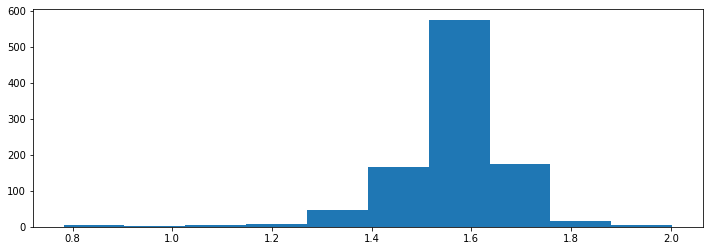

In [32]:
y_predict = model_main.predict(x_train)
plt.hist(y_predict)